### Dataset Loader

In [3]:
import os
import numpy as np
import librosa
import tensorflow as tf
import soundfile as sf
from IPython.display import Audio

def get_file_paths(directory, instrument_family):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav") and instrument_family in file:
                file_paths.append(os.path.join(root, file))
                #print(f"Found {file_paths[-1]}")
    return file_paths

def check_pitch_range(y, sr=16000, min_pitch=24, max_pitch=84):
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    pitches = np.argmax(pitches, axis=0)
    pitches = librosa.hz_to_midi(pitches)
    pitches = pitches[pitches > 0]
    return np.all((pitches >= min_pitch) & (pitches <= max_pitch))

def load_audio_files(file_paths, max_samples=500, sr=16000):
    audio_data = []
    for file_path in file_paths:
        if len(audio_data) >= max_samples:
            break
        try:
            y, _ = librosa.load(file_path, sr=sr)
            y = librosa.util.normalize(y)
            if check_pitch_range(y):
                audio_data.append(y)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")
    return np.expand_dims(np.array(audio_data), -1)

# Chose from : 'bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ', 'reed', 'string', 'synth_lead', 'vocal'
instrument_family = 'organ'

train_file_paths = get_file_paths('../Nsynth/nsynth-train/audio', instrument_family)
valid_file_paths = get_file_paths('../Nsynth/nsynth-valid/audio', instrument_family)
test_file_paths = get_file_paths('../Nsynth/nsynth-test/audio', instrument_family)

train_data = load_audio_files(train_file_paths, max_samples=500)
valid_data = load_audio_files(valid_file_paths, max_samples=100)
test_data = load_audio_files(test_file_paths, max_samples=100)

Python(51788) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(51789) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/nishantsaxena/Downloads/9491/.venv/lib/python3.11/site-packages/librosa/core/convert.py:1095: RuntimeWarning: divide by zero encountered in log2
  midi: np.ndarray = 12 * (np.log2(np.asanyarray(frequencies)) - np.log2(440.0)) + 69


In [3]:
print(f"Loaded {len(train_data)} audio samples")
print(f"Train audio data shape: {train_data.shape}")
print(f"Loaded {len(valid_data)} audio samples")
print(f"Validation audio data shape: {valid_data.shape}")
print(f"Loaded {len(test_data)} audio samples")
print(f"Test audio data shape: {test_data.shape}")

Loaded 500 audio samples
Train audio data shape: (500, 64000, 1)
Loaded 100 audio samples
Validation audio data shape: (100, 64000, 1)
Loaded 100 audio samples
Test audio data shape: (100, 64000, 1)


### Model

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Activation, Add, Dropout, BatchNormalization, Concatenate, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Residual block
def residual_block(x, dilation_rate):
    r = Conv1D(64, kernel_size=2, dilation_rate=dilation_rate, padding='causal')(x)
    r = Activation('relu')(r)
    r = Dropout(0.2)(r)
    r = BatchNormalization()(r)
    r = Conv1D(64, kernel_size=2, dilation_rate=dilation_rate, padding='causal')(r)
    r = Activation('relu')(r)
    return Add()([x, r])

# Encoder
def build_encoder(input_shape):
    audio_input = Input(shape=input_shape)

    x = Conv1D(64, kernel_size=2, dilation_rate=1, padding='causal')(audio_input)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    # dilation_rates = [1, 2, 4, 8, 16]
    dilation_rates = [1, 4, 16]
    for dilation_rate in dilation_rates:
        x = residual_block(x, dilation_rate)

    encoded = Conv1D(32, kernel_size=1, activation='relu')(x)
    encoder = Model(audio_input, encoded)
    return encoder

# Decoder
def build_decoder(encoded_shape):
    encoded_input = Input(shape=encoded_shape)

    x = Conv1D(64, kernel_size=1, activation='relu')(encoded_input)

    # dilation_rates = [16, 8, 4, 2, 1]
    dilation_rates = [16, 4, 1]
    for dilation_rate in dilation_rates:
        x = residual_block(x, dilation_rate)

    outputs = Conv1D(1, kernel_size=1, activation='linear')(x)
    decoder = Model(encoded_input, outputs)
    return decoder

# Autoencoder
def build_wavenet_autoencoder(input_shape):
    encoder = build_encoder(input_shape)
    # encoder.summary()
    encoded_shape = encoder.output_shape[1:]
    decoder = build_decoder(encoded_shape)
    # decoder.summary()

    audio_input = Input(shape=input_shape)
    encoded = encoder(audio_input)
    outputs = decoder(encoded)

    autoencoder = Model(audio_input, outputs)
    return autoencoder


In [9]:
input_shape = train_data.shape[1:]

wavenet_autoencoder = build_wavenet_autoencoder(input_shape)
wavenet_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mae')
wavenet_autoencoder.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 64000, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_6 (Functional)       │ (None, 64000, 32)      │        52,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_7 (Functional)       │ (None, 64000, 1)       │        52,481 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,057 (410.38 KB)

 Trainable params: 104,289 (407.38 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - loss: 0.6385 - val_loss: 0.1940
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - loss: 0.1456 - val_loss: 0.1816
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 302s 5s/step - loss: 0.0755 - val_loss: 0.1723
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 318s 5s/step - loss: 0.0599 - val_loss: 0.1554
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - loss: 0.0489 - val_loss: 0.1408
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 306s 5s/step - loss: 0.0373 - val_loss: 0.1176
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - loss: 0.0337 - val_loss: 0.1121
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 315s 5s/step - loss: 0.0392 - val_loss: 0.0945
Epoch 9/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 346s 5s/step - loss: 0.0298 - val_loss: 0.0833
Epoch 10/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 361s 6s/step - loss: 0.0296 - val_loss: 0.0494
Epoch 11/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 347s 6s/step - loss: 0.0260 - val_loss: 0.0447
Epoch 12/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 333s 5s/step - loss: 0.0

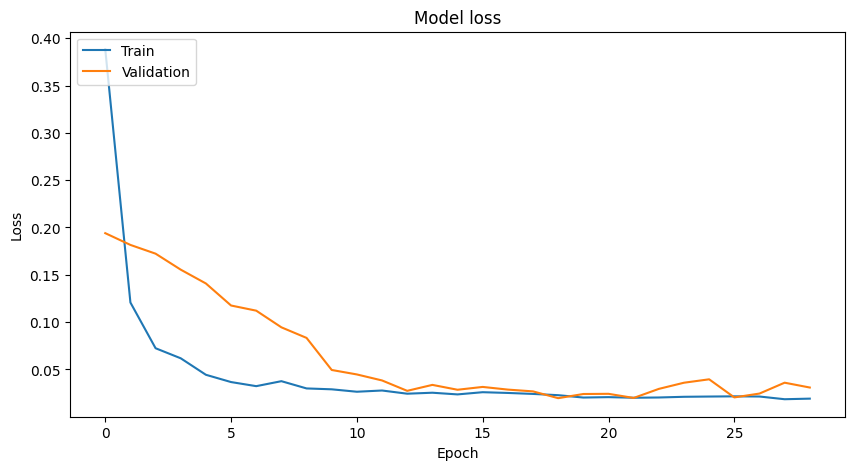

In [10]:
import matplotlib.pyplot as plt

# Callbacks
callbacks = [
    tf.keras.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('wavenet_autoencoder.keras', save_best_only=True)
]

# Training
history = wavenet_autoencoder.fit(
    train_data, train_data,
    validation_data=(valid_data, valid_data),
    epochs=50,
    batch_size=8,
    callbacks=callbacks
)

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', marker='o')
plt.plot(history['val_loss'], label='Validation Loss', marker='x')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Save the history object

In [ ]:
# Best model already saved using callback during training

import pickle
with open('history_wavenet.pkl','wb') as file:
    pickle.dump(history.history, file)

### Load the model

In [1]:
from tensorflow.keras.models import load_model

# Load the trained model
wavenet_autoencoder = load_model('wavenet_autoencoder.keras')

### Helper Functions

In [22]:
import matplotlib.pyplot as plt
import os
from scipy.io.wavfile import write

# Method to compute and plot the spectrogram
def plot_spectrogram(audio, sr=16000):
    S = librosa.feature.melspectrogram(y=audio.astype(np.float32), sr=sr, n_mels=128)
    S_dB = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# Method to display the audio waveform
def display_waveform(audio, sr=16000):
    audio_duration = len(audio) / sr
    plt.figure(figsize=(12, 4))
    plt.plot(np.linspace(0, audio_duration, len(audio)), audio)
    plt.title('Generated Audio Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Function to save audio files
def save_audio_files(audio_data, sr, base_filename, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    for i, audio in enumerate(audio_data):
        filename = f"{base_filename}_{i}.wav"
        file_path = os.path.join(folder_name, filename)
        # Ensure audio is properly scaled to [-1, 1] for saving
        audio = np.clip(audio, -1.0, 1.0)
        # Convert to 16-bit PCM format
        write(file_path, sr, (audio * 32767).astype(np.int16))
        print(f"Saved generated audio to {file_path}")

### Generate audio sample

In [ ]:
# Prepare a test sample for generation
test_sample = test_data[0:1]  # Take the first sample from the test dataset

# Generate audio
generated_audio = wavenet_autoencoder.predict(test_sample)

# Post-process and save the generated audio
generated_audio = np.squeeze(generated_audio)  # Remove the batch and channel dimensions
output_path = 'generated_audio.wav'
sf.write(output_path, generated_audio, 16000)  # Save as a .wav file with a sample rate of 16 kHz

# Listen to the generated audio
Audio(output_path)

# Plot the original and generated audio waveforms
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(test_sample[0])
plt.title('Original Audio')

plt.subplot(1, 2, 2)
plt.plot(generated_audio)
plt.title('Generated Audio')

plt.show()

In [17]:
# best_model = load_model('wavenet_autoencoder.keras')

from scipy.io.wavfile import write

# Generate audio using the test dataset
generated_audio = wavenet_autoencoder.predict(test_data)

save_audio_files(generated_audio.squeeze(), 16000, "generated_test_audio", "wavenet")

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step
Saved generated audio to wavenet/generated_test_audio_0.wav
Saved generated audio to wavenet/generated_test_audio_1.wav
Saved generated audio to wavenet/generated_test_audio_2.wav
Saved generated audio to wavenet/generated_test_audio_3.wav
Saved generated audio to wavenet/generated_test_audio_4.wav
Saved generated audio to wavenet/generated_test_audio_5.wav
Saved generated audio to wavenet/generated_test_audio_6.wav
Saved generated audio to wavenet/generated_test_audio_7.wav
Saved generated audio to wavenet/generated_test_audio_8.wav
Saved generated audio to wavenet/generated_test_audio_9.wav
Saved generated audio to wavenet/generated_test_audio_10.wav
Saved generated audio to wavenet/generated_test_audio_11.wav
Saved generated audio to wavenet/generated_test_audio_12.wav
Saved generated audio to wavenet/generated_test_audio_13.wav
Saved generated audio to wavenet/generated_test_audio_14.wav
Saved generated audio to wavenet/generated_test_audio_15.w

In [18]:
import IPython.display as ipd

generated_audio = librosa.load('./wavenet/generated_test_audio_99.wav', sr=16000)[0]
# Call the methods
ipd.Audio(generated_audio, rate=16000)


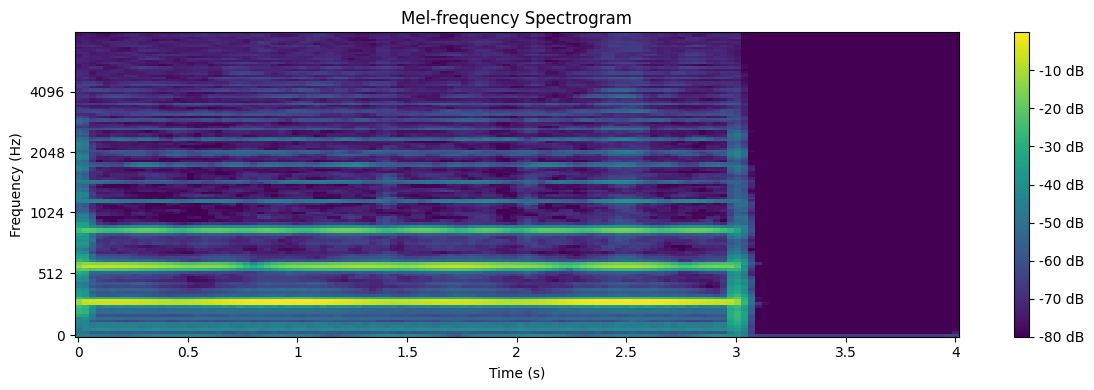

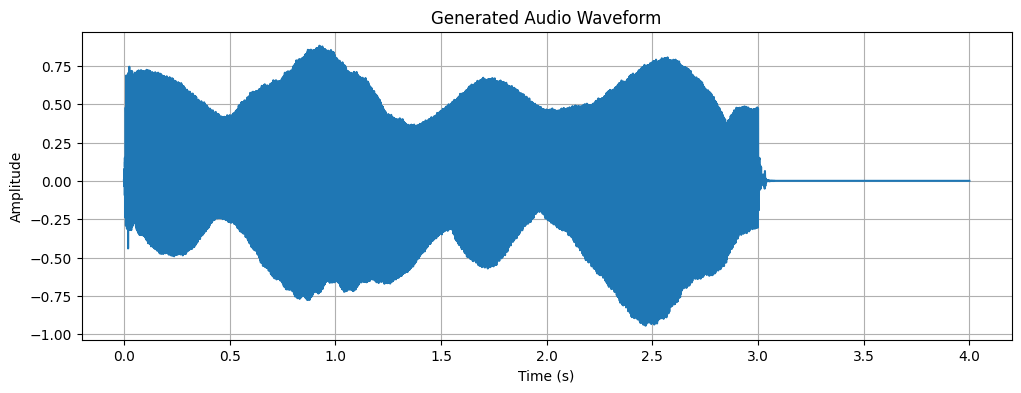

In [23]:
plot_spectrogram(generated_audio)
display_waveform(generated_audio)

In [12]:
save_audio_files(test_data.squeeze(), 16000, "test_audio", "wavenet_test")

Saved generated audio to wavenet_test/test_audio_0.wav
Saved generated audio to wavenet_test/test_audio_1.wav
Saved generated audio to wavenet_test/test_audio_2.wav
Saved generated audio to wavenet_test/test_audio_3.wav
Saved generated audio to wavenet_test/test_audio_4.wav
Saved generated audio to wavenet_test/test_audio_5.wav
Saved generated audio to wavenet_test/test_audio_6.wav
Saved generated audio to wavenet_test/test_audio_7.wav
Saved generated audio to wavenet_test/test_audio_8.wav
Saved generated audio to wavenet_test/test_audio_9.wav
Saved generated audio to wavenet_test/test_audio_10.wav
Saved generated audio to wavenet_test/test_audio_11.wav
Saved generated audio to wavenet_test/test_audio_12.wav
Saved generated audio to wavenet_test/test_audio_13.wav
Saved generated audio to wavenet_test/test_audio_14.wav
Saved generated audio to wavenet_test/test_audio_15.wav
Saved generated audio to wavenet_test/test_audio_16.wav
Saved generated audio to wavenet_test/test_audio_17.wav
Sa